# Логистическая регрессия. Практическая работа

## Цель практической работы

Вы уже делали задание, в котором с помощью метода ближайших соседей оценивали склонность клиента банка откликнуться или не откликнуться на предложение.

В этом практическом задании ваши цели:
*  решить эту же задачу с помощью логистической регрессии;
*  потренироваться в подборе порога; 
*  потренироваться в подборе гиперпараметров модели.

## Что входит в работу

*  Загрузить данные для задачи.
*  Обучить метод ближайших соседей с заданным количеством соседей k, вычислить метрики.
*  Обучить логистическую регрессию с параметрами по умолчанию, вычислить метрики.
*  Подобрать порог модели, вычислить метрики.
*  Подобрать гиперпараметр С (константа регуляризации) модели, вычислить метрики.

## Что оценивается

*  Выполнены все этапы задания: код запускается, отрабатывает без ошибок; подробно и обоснованно написаны текстовые выводы, где это требуется.

## Формат сдачи
Выполните предложенные задания — впишите свой код (или, если требуется, текст) в ячейки после комментариев. 

*Комментарии — это текст, который начинается с символа #. Например: # ваш код здесь.*

Сохраните изменения, используя опцию Save and Checkpoint из вкладки меню File или кнопку Save and Checkpoint на панели инструментов. Итоговый файл в формате .ipynb (файл Jupyter Notebook) загрузите в личный кабинет и отправьте на проверку.

In [1]:
# подключим библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# считаем данные
data = pd.read_csv('ClientsData.csv')

In [3]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


В этом ноутбуке нам придётся подбирать гиперпараметры модели, а ещё порог. Поэтому, чтобы не переобучиться, разобъём данные на трейн, валидацию и тест.

*  Обучать модели будем на тренировочных данных.
*  Подбирать необходимые величины — по валидации.
*  Оценивать качество — на тесте.

In [4]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X = data.drop('TARGET', axis=1)
y = data['TARGET']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=123)

В задании по методу ближайших соседей было найдено, что оптимальное число соседей k = 9.

Обучите на тренировочных данных KNN с k = 9 и выведите матрицу ошибок, а также значение метрик precision и recall на тестовых данных.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [7]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(Xtrain, ytrain)

pred_train = knn.predict(Xtrain)
pred_test = knn.predict(Xtest)

print("Confusion martix train", confusion_matrix(ytrain, pred_train))
print("Presicion train = ", precision_score(ytrain, pred_train))
print("Recall train = ", recall_score(ytrain, pred_train))

print("Confusion martix", confusion_matrix(ytest, pred_test))
print("Presicion = ", precision_score(ytest, pred_test))
print("Recall = ", recall_score(ytest, pred_test))


Confusion martix train [[6543   16]
 [ 871   29]]
Presicion train =  0.6444444444444445
Recall train =  0.03222222222222222
Confusion martix [[3981   27]
 [ 555    4]]
Presicion =  0.12903225806451613
Recall =  0.007155635062611807


Какой вывод можно сделать:
- для класса 0 — клиент не откликнулся — мы получили достаточно высокие значения TP в том числе потому, что представителей этого класса больше;
- для класса 1 — клиент откликнулся — мы получили низкие значения TN.

Поэтому значения precision и recall низкие. Модель даёт неудовлетворительные результаты, так как находит мало клиентов, которые откликнутся на предложение.



Обучите логистическую регрессию с параметрами по умолчанию и посмотрите на метрики.

Везде дальше при оценке метрик надо выводить confusion_matrix, precision и recall.

In [20]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Xtrain, ytrain)

pred_train_lr = lr.predict(Xtrain)
pred_test_lr = lr.predict(Xtest)

Presicion train =  0.125
Recall train =  0.0011111111111111111


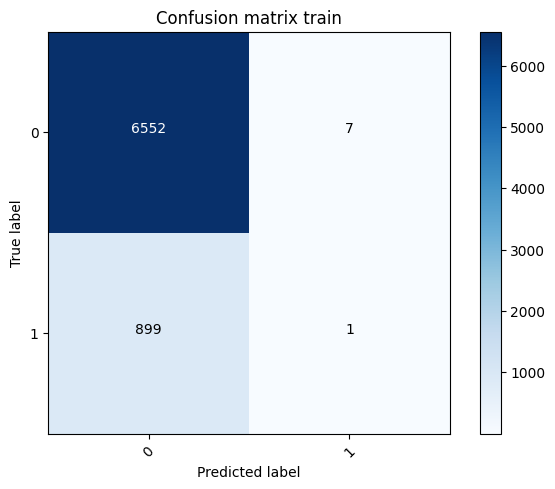

In [23]:
plot_confusion_matrix(
    confusion_matrix(ytrain, pred_train_lr), 
    classes=['0','1'],
    title='Confusion matrix train',
    )
print("Presicion train = ", precision_score(ytrain, pred_train_lr))
print("Recall train = ", recall_score(ytrain, pred_train_lr))

Presicion =  0.0
Recall =  0.0


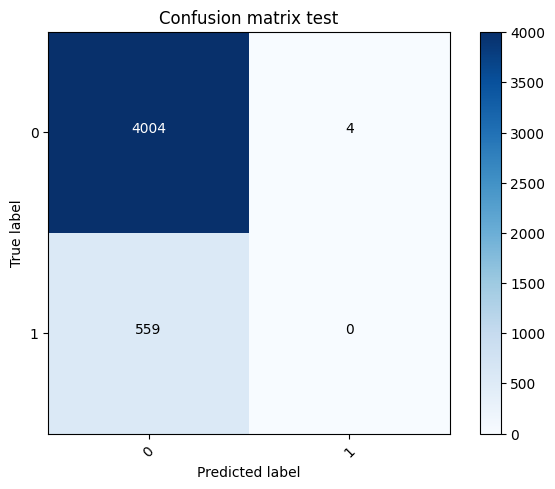

In [25]:
plot_confusion_matrix(
    confusion_matrix(ytest, pred_test_lr), 
    classes=['0','1'],
    title='Confusion matrix test',
    )
print("Presicion = ", precision_score(ytest, pred_test_lr))
print("Recall = ", recall_score(ytest, pred_test_lr))

Наша цель — найти как можно больше клиентов, которые откликнутся на предложение. А модель таких не находит. 

Мы помним, что метод predict_proba у логистической регрессии предсказывает математические (то есть корректные) вероятности классов. Предскажите вероятности классов с помощью обученной логистической регрессии на тестовых данных и выведите вероятности положительного класса для первых десяти объектов. 

Глядя на полученные вероятности, попробуйте объяснить, почему вы получили именно такую матрицу ошибок и такие значения точности с полноты.

In [19]:
pred_proba_test = lr.predict_proba(Xtest)

for i in pred_proba_test[:10]:
    print(i[1])

0.07132884100425284
0.11530912312481117
0.29188150545041786
0.21909769239195825
0.13873442492465077
0.04492491696857937
0.06424642019499123
0.03588637053319898
0.05715778425445937
0.06871210382376372


### Ответ

In [ ]:
# По умолчанию порог 0.5, и соответственно, после перевода в классы эти вероятности станус 0. 
# Вот мы в итоге и получаем, что 0-й будет гораздо больше. 
# А такие маленькие (или нулевые) значения полноты и точности, получаются из их формул - TP, либо очень маленький, либо равен 0, а если 0 разделить на любое число то будет 0 :)

Давайте уточним цель. Пусть нам нужно найти как можно больше клиентов, которые откликнутся на предложение, то есть максимизировать полноту (recall). 

При этом хочется, чтобы точность модели (precision) не была очень низкой. Заказчик посмотрел на результаты работы KNN и потребовал, чтобы точность была не ниже, чем у KNN: $precision \geq 0.13$.

Давайте будем изменять порог для перевода вероятности в классы так, чтобы:
*   максимизировать значение recall
*   при условии, что $precision \geq 0.13$.

Если мы будем подбирать порог по тестовой выборке, то, по сути, обучимся на ней и, значит, переобучимся. Это плохо. 

Поэтому предскажите вероятности на валидационной выборке и подберите порог по ней (Xval, yval), а затем посмотрите, какое качество для найденного порога вы получите на тестовых данных.

In [37]:
# для каждого значения порога переведите вероятности в классы
# посчитайте метрики

# напечатайте порог, для которого получается максимальная полнота, при precision >= 0.13
probs_val = lr.predict_proba(Xval)

max_recall = -1
thr = -1
prec = -1

for threshold in np.arange(0.05, 1, 0.001):
    classes = (probs_val[:, 1] > threshold).astype(int)

    precision =  precision_score(yval, classes)
    recall = recall_score(yval, classes)
    if recall > max_recall and precision >= 0.13:
        max_recall = recall
        prec = precision
        thr = threshold

print("threshold =", thr)
print("precision =", prec)
print("recall =", max_recall)

threshold = 0.07300000000000002
precision = 0.13045284586622352
recall = 0.8895184135977338


In [40]:
# по найденному порогу переведите вероятности в классы на тесте и напечатайте метрики

probs_test = lr.predict_proba(Xtest)

classes = (probs_test[:, 1] > 0.073).astype(int)

print("precision =", precision_score(ytest, classes))
print("recall =", recall_score(ytest, classes))

precision = 0.13779988297249854
recall = 0.8425760286225402


Сделайте вывод. Смогли ли мы с помощью подбора порога добиться большего значения recall, чем у KNN? 

In [ ]:
# Да, изменяя порог, мы смогли значительно улучшить recall. С 0.007 до 0.84

А ещё, чтобы улучшить качество предсказания, можно подбирать значение гиперпараметра C у логистической регрессии. Для каждого значения C придётся подбирать свой порог, поэтому:  

1. Обучите для значений C из диапазона [0.05, 0.15, 0.25, ...., 10.05] логистическую регрессию (на тренировочных данных).

2. Для каждой из обученных моделей во внутреннем цикле подберите оптимальный порог (как в предыдущем задании) — на валидационных данных.



В качестве результата выведите значение C и порога для модели, которая даёт наилучшие значения метрик (наибольший recall при ограничении на $precision \geq 0.13$).

Также напечатайте полученные метрики (матрицу ошибок, точность и полноту) для лучшей модели — на тестовых данных.

In [43]:
regs = []
recalls = []
thresholds = []
precisions = []

for reg in np.arange(0.001, 1, 0.01):
    # обучите логистическую регрессию с C=reg
    lr = LogisticRegression(C=reg, random_state=42)
    lr.fit(Xtrain, ytrain)

    probs_val = lr.predict_proba(Xval)

    max_recall = -1
    thr = -1
    prec = -1

    for threshold in np.arange(0.05, 0.25, 0.001):
        # подберите оптимальный порог как в задании выше
        classes = (probs_val[:, 1] > threshold).astype(int)

        precision =  precision_score(yval, classes)
        recall = recall_score(yval, classes)
        if recall > max_recall and precision >= 0.13:
            max_recall = recall
            prec = precision
            thr = threshold

    recalls.append(max_recall)
    thresholds.append(thr)
    precisions.append(prec)
    regs.append(reg)

In [44]:
# выведите значения C, precision, recall, threshold для наилучшей по заданным условиям модели
print(regs)
print(recalls)
print(thresholds)
print(precisions)

[0.001, 0.011, 0.020999999999999998, 0.030999999999999996, 0.040999999999999995, 0.05099999999999999, 0.06099999999999999, 0.071, 0.08099999999999999, 0.09099999999999998, 0.10099999999999998, 0.11099999999999999, 0.12099999999999998, 0.13099999999999998, 0.141, 0.15099999999999997, 0.16099999999999998, 0.17099999999999999, 0.18099999999999997, 0.19099999999999998, 0.20099999999999996, 0.21099999999999997, 0.22099999999999997, 0.23099999999999996, 0.24099999999999996, 0.25099999999999995, 0.26099999999999995, 0.27099999999999996, 0.28099999999999997, 0.291, 0.30099999999999993, 0.31099999999999994, 0.32099999999999995, 0.33099999999999996, 0.34099999999999997, 0.3509999999999999, 0.36099999999999993, 0.37099999999999994, 0.38099999999999995, 0.39099999999999996, 0.4009999999999999, 0.4109999999999999, 0.42099999999999993, 0.43099999999999994, 0.44099999999999995, 0.45099999999999996, 0.4609999999999999, 0.4709999999999999, 0.4809999999999999, 0.49099999999999994, 0.5009999999999999, 0.

In [ ]:
# с помощью найденных C и threshold обучите модель на тренировочных данных, сделайте предсказание на тесте и по найденному порогу получите классы
# напечатайте метрики

Влияет ли изменение гиперпараметра C на качество модели (и, соответственно, метрики) в этой задаче?

In [ ]:
# ваш вывод здесь

Ответьте развёрнуто на следующие вопросы:

* Удалось ли при помощи логистической регрессии и подбора порога превзойти качество метода ближайших соседей в этой задаче? 

* Смогли ли мы при помощи этой модели получить высокий recall при ограничениях, поставленных заказчиком?


In [ ]:
# ваш вывод здесь